In [97]:
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 20)

<br>

# Functions

In [2]:
def M2Q(df_in):
    d = {"M03":"Q1", "M06":"Q2", "M09":"Q3", "M12":"Q4"}
    df_out = df_in[df_in['TIME'].apply(lambda x: x[-3:] in list(d.keys()))].copy()
    df_out.TIME = df_out['TIME'].apply(lambda x: x[:4]+d[x[-3:]]).copy()
    return(df_out)

def Qp1(df_in):
    d = {"Q1":"Q2", "Q2":"Q3", "Q3":"Q4", "Q4":"Q1"}
    df_out = df_in.copy()
    df_out.TIME = df_out['TIME'].apply(lambda x: str(int(x[:-2])+1)+d[x[-2:]] if x[-1:] == "4" else x[:-2]+d[x[-2:]]).copy()
    return(df_out)

<br>

# Data

In [3]:
path = "./data/csvs/"
!sed -i "s/://g" ./data/*

In [4]:
#!head -n 1 data/sts_trtu_q_Label.csv

>## Quarterly

In [5]:
# DATASET Construction - quarterly data - index (2015 = 100) (NACE Rev. 2) [ei_isbu_q]
ei_isbu_q = pd.read_csv("./data/ei_isbu_q_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
ei_isbu_q_lag = Qp1(ei_isbu_q.copy())

# DATASET Final consumption aggregates [namq_10_fcs]
namq_10_fcs = pd.read_csv("./data/namq_10_fcs_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
namq_10_fcs_lag = Qp1(namq_10_fcs.copy())

# DATASET: GDP and main components  (output, expenditure and income) [namq_10_gdp]
namq_10_gdp = pd.read_csv("./data/namq_10_gdp_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
namq_10_gdp_lag = Qp1(namq_10_gdp.copy())

# DATASET Building permits - quarterly data [sts_cobp_q]
sts_cobp_q = pd.read_csv("./data/sts_cobp_q_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
sts_cobp_q_lag = Qp1(sts_cobp_q.copy())

# DATASET Production in construction - quarterly data [sts_copr_q]
sts_copr_q = pd.read_csv("./data/sts_copr_q_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
sts_copr_q_lag = Qp1(sts_copr_q.copy())

# DATASET Production in industry - quarterly data [sts_inpr_q]
sts_inpr_q = pd.read_csv("./data/sts_inpr_q_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
sts_inpr_q_lag = Qp1(sts_inpr_q.copy())

# DATASET Turnover in industry, total - quarterly data [sts_intv_q]
sts_intv_q = pd.read_csv("./data/sts_intv_q_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
sts_intv_q_lag = Qp1(sts_intv_q.copy())

# DATASET Turnover and volume of sales in wholesale and retail trade - quarterly data [sts_trtu_q]
sts_trtu_q = pd.read_csv("./data/sts_trtu_q_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna()
sts_trtu_q_lag = Qp1(sts_trtu_q.copy())

>## Monthly

In [6]:
# DATASET Euro-zone Business Climate Indicator - monthly data [ei_bsci_m_r2]
ei_bsci_m_r2_1 = M2Q(pd.read_csv("./data/ei_bsci_m_r2_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna())

# DATASET Sentiment indicators - monthly data [ei_bssi_m_r2]
ei_bssi_m_r2 = M2Q(pd.read_csv("./data/ei_bssi_m_r2_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna())

# DATASET Effective exchange rates indices - monthly data [ei_mfef_m]
ei_mfef_m = M2Q(pd.read_csv("./data/ei_mfef_m_1_Data.csv", low_memory=False, usecols=lambda x: x not in ["Flag and Footnotes"]).dropna())

**Dealing with ids:**

In [7]:
for df in [ei_isbu_q, ei_isbu_q_lag, namq_10_fcs, namq_10_fcs_lag, namq_10_gdp, 
           namq_10_gdp_lag, sts_cobp_q, sts_cobp_q_lag, sts_copr_q, sts_copr_q_lag, 
           sts_inpr_q, sts_inpr_q_lag, sts_intv_q, sts_intv_q_lag, sts_trtu_q, 
           sts_trtu_q_lag, ei_isbu_q, ei_isbu_q_lag, namq_10_fcs, namq_10_fcs_lag, 
           namq_10_gdp, namq_10_gdp_lag, sts_cobp_q, sts_cobp_q_lag, sts_copr_q, sts_copr_q_lag, 
           sts_inpr_q, sts_inpr_q_lag, sts_intv_q, sts_intv_q_lag, sts_trtu_q, sts_trtu_q_lag, ei_bsci_m_r2_1, ei_bssi_m_r2, ei_mfef_m]:
    df["ID"] = df["TIME"]+df["GEO"]
    df.Value = df.Value.replace(regex=r'[,]+', value='').astype(np.float)
    


># OECD

In [8]:
def OECD():
    GEO_LABEL2GEO = dict(zip(namq_10_gdp.GEO_LABEL.values, namq_10_gdp.GEO.values)); GEO_LABEL2GEO["Germany"] = "DE"
    df_in = pd.read_csv("data/KEI_13112018143436794_[v1-oecd].csv")
    df_in["GEO"] = df_in.Country.map(GEO_LABEL2GEO)
    df_in = df_in[df_in.GEO.notnull()]
    df_in["ID"] = df_in.TIME.str[:4]+df_in.TIME.str[-2:]+df_in.GEO
    return(df_in)

In [9]:
OECD = OECD()

<br>

# $C$

>## $Cd$

In [160]:
def Cd(model_variables=[], version=0, all_boolean=False, country_dummies=True):
    df_in = pd.DataFrame(sorted(list(set(namq_10_fcs.ID))), columns=["ID"])
    
    ###########################################################################################
    
    # Chain linked volumes, percentage change compared to same period in previous year
    var = "CLV_PCH_SM"
    selec = namq_10_fcs[(namq_10_fcs.NA_ITEM=="P311_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Chain linked volumes, percentage change on previous period
    var = "CLV_PCH_PRE"
    if var in model_variables or all_boolean:
        selec = namq_10_fcs_lag[(namq_10_fcs_lag.NA_ITEM=="P311_S14")&(namq_10_fcs_lag.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Business Climate Indicator
    var = "BS-BCI"
    if var in model_variables or all_boolean:
        dic_BCI = dict(zip(ei_bsci_m_r2_1.TIME.values, ei_bsci_m_r2_1.Value.values))
        df_in[var] = df_in.ID.str[:-2].map(dic_BCI)
    
    # Retail Confidence Indicator
    var = "BS-RCI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
        
    # Services Confidence Indicator
    var = "BS-SCI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Consumer Confidence Indicator
    var = "BS-CSMCI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: MIG - Durable Consumer Goods
    var = "MIG_DCOG"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[sts_inpr_q.NACE_R2==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Manufacture of motor vehicles, trailers, semi-trailers and of other transport equipment
    var = "C29_C30"
    if var in model_variables or all_boolean:
        selec = sts_intv_q[sts_intv_q.NACE_R2==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
        
    # Harmonised unemployment rate all persons, s.a.
    var = "LRHUTTTT"
    if var in model_variables or all_boolean:
        selec = OECD[OECD.SUBJECT==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
        
    # Passenger car registrations, s.a.
    var = "SLRTCR03"
    if var in model_variables or all_boolean:
        selec = OECD[OECD.SUBJECT==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    ###########################################################################################
    
    # Dummies
    if country_dummies:
        countries = set(namq_10_fcs.GEO); countries.remove('PT')
        for country in sorted(list(countries)):
            df_in[country] = (df_in.ID.str[-2:] == country).astype(int)
    
    Cd = df_in.dropna().copy(); Cd.set_index("ID", inplace=True)
    Cd = Cd.loc[:, (Cd != 0).any(axis=0)].copy()
    del var, selec, df_in
    
    ###########################################################################################
    
    # Save
    if version != 0:
        Cd.to_csv("./regressions/Cd"+str(version)+".csv")
        
    ###########################################################################################
    
    # Regression
    X = sm.add_constant(Cd.loc[:, Cd.columns != "CLV_PCH_SM"].copy())
    y = Cd.loc[:, "CLV_PCH_SM"].copy()
    results = sm.OLS(y, X).fit()
    print(results.summary())
    
    return(Cd)

In [161]:
Cd1 = Cd(["BS-RCI-BAL", "BS-SCI-BAL", "BS-CSMCI-BAL"], 1)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     41.82
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          1.26e-144
Time:                        07:04:28   Log-Likelihood:                -5697.7
No. Observations:                1590   AIC:                         1.144e+04
Df Residuals:                    1566   BIC:                         1.157e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.6867      1.146      4.964   

In [162]:
Cd2 = Cd(["BS-RCI-BAL", "BS-SCI-BAL", "BS-CSMCI-BAL", "SLRTCR03", "C29_C30"], 2)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     51.95
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          5.33e-148
Time:                        07:04:34   Log-Likelihood:                -3873.9
No. Observations:                1118   AIC:                             7792.
Df Residuals:                    1096   BIC:                             7902.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.0236      2.056      2.443   

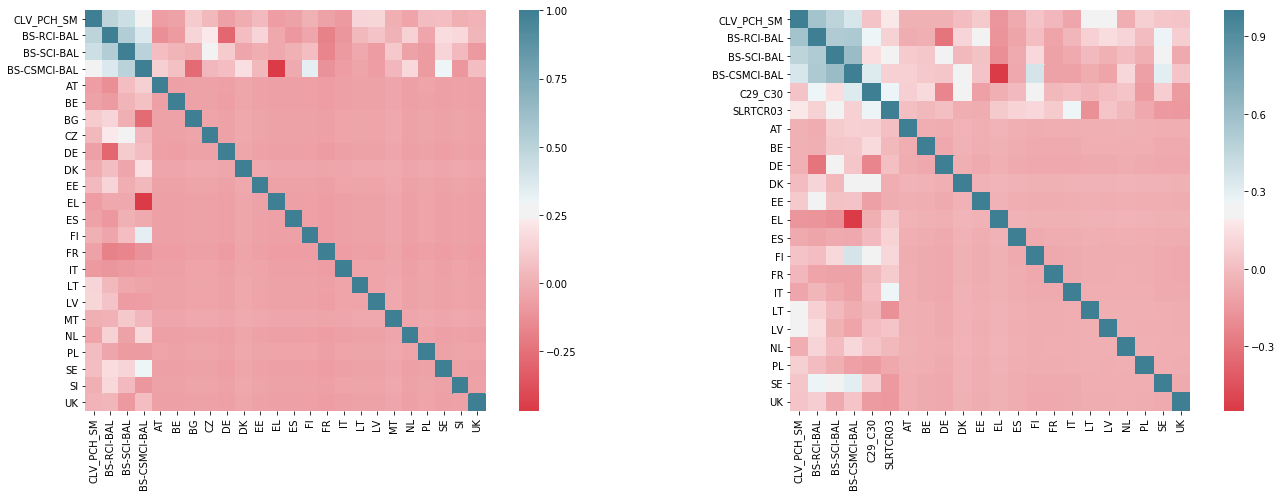

In [135]:
f, axes = plt.subplots(1, 2, figsize=(20, 7)); axes = axes.flatten()
sns.heatmap(Cd1.corr(), mask=np.zeros_like(Cd1.corr(), dtype=np.bool),
            cmap=sns.diverging_palette(10, 220, as_cmap=True),square=True, ax=axes[0]);
sns.heatmap(Cd2.corr(), mask=np.zeros_like(Cd2.corr(), dtype=np.bool),
            cmap=sns.diverging_palette(10, 220, as_cmap=True),square=True, ax=axes[1])
plt.tight_layout();

In [163]:
Cd3 = Cd(["BS-RCI-BAL", "BS-SCI-BAL", "BS-CSMCI-BAL", "SLRTCR03", "C29_C30", "CLV_PCH_PRE"], 3)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     77.26
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          8.26e-205
Time:                        07:04:52   Log-Likelihood:                -3736.3
No. Observations:                1118   AIC:                             7519.
Df Residuals:                    1095   BIC:                             7634.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.1473      1.822      1.727   

In [164]:
Cd_all = Cd(all_boolean=True)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     68.37
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          2.38e-201
Time:                        07:04:56   Log-Likelihood:                -3647.4
No. Observations:                1092   AIC:                             7347.
Df Residuals:                    1066   BIC:                             7477.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.9315      3.412     -1.152   

>## $Cnd$

In [153]:
def Cnd(model_variables=[], version=0, all_boolean=False, country_dummies=True):

    df_in = pd.DataFrame(sorted(list(set(namq_10_fcs.ID))), columns=["ID"])
    
    ###########################################################################################
    
    # Chain linked volumes, percentage change compared to same period in previous year
    var = "CLV_PCH_SM"
    selec = namq_10_fcs[(namq_10_fcs.NA_ITEM=="P312N_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Chain linked volumes, percentage change on previous period
    var = "CLV_PCH_PRE"
    if var in model_variables or all_boolean:
        selec = namq_10_fcs_lag[(namq_10_fcs_lag.NA_ITEM=="P312N_S14")&(namq_10_fcs_lag.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Business Climate Indicator
    var = "BS-BCI"
    if var in model_variables or all_boolean:
        dic_BCI = dict(zip(ei_bsci_m_r2_1.TIME.values, ei_bsci_m_r2_1.Value.values))
        df_in[var] = df_in.ID.str[:-2].map(dic_BCI)
    
    # Retail Confidence Indicator
    var = "BS-RCI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Services Confidence Indicator
    var = "BS-SCI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Consumer Confidence Indicator
    var = "BS-CSMCI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: MIG - Non-Durable Consumer Goods
    var = "MIG_NDCOG"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[sts_inpr_q.NACE_R2==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Retail sale of food, beverages and tobacco
    var = "G47_FOOD"
    if var in model_variables or all_boolean:
        selec = sts_trtu_q[sts_trtu_q.NACE_R2==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Retail sale of non-food products (except fuel)
    var = "G47_NFOOD_X_G473"
    if var in model_variables or all_boolean:
        selec = sts_trtu_q[sts_trtu_q.NACE_R2==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Retail trade, except of motor vehicles, motorcyles and fuel
    var = "G47_X_G473"
    if var in model_variables or all_boolean:
        selec = sts_trtu_q[sts_trtu_q.NACE_R2==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Harmonised unemployment rate all persons, s.a.
    var = "LRHUTTTT"
    if var in model_variables or all_boolean:
        selec = OECD[OECD.SUBJECT==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    ###########################################################################################
    
    # Dummies
    if country_dummies:
        countries = set(namq_10_fcs.GEO); countries.remove('PT')
        for country in sorted(list(countries)):
            df_in[country] = (df_in.ID.str[-2:] == country).astype(int)
    
    Cnd = df_in.dropna().copy().set_index("ID")
    Cnd = Cnd.loc[:, (Cnd != 0).any(axis=0)].copy()
    
    del var, selec, df_in
    
    ###########################################################################################
    
    # Save
    if version != 0:
        Cnd.to_csv("./regressions/Cnd"+str(version)+".csv")
    
    ###########################################################################################
    
    # Regression
    X = sm.add_constant(Cnd.loc[:, Cnd.columns != "CLV_PCH_SM"].copy())
    y = Cnd.loc[:, "CLV_PCH_SM"].copy()
    results = sm.OLS(y, X).fit()
    print(results.summary())
    
    return(Cnd)

In [152]:
Cnd1 = Cnd(["BS-RCI-BAL", "G47_NFOOD_X_G473", "G47_FOOD"], 1)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     194.7
Date:                Wed, 14 Nov 2018   Prob (F-statistic):               0.00
Time:                        07:00:34   Log-Likelihood:                -14110.
No. Observations:                6138   AIC:                         2.827e+04
Df Residuals:                    6114   BIC:                         2.843e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.3988      0.150  

In [155]:
Cnd2 = Cnd(["BS-RCI-BAL", "G47_NFOOD_X_G473", "G47_FOOD", "BS-SCI-BAL", "LRHUTTTT"], 2)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     239.9
Date:                Wed, 14 Nov 2018   Prob (F-statistic):               0.00
Time:                        07:02:38   Log-Likelihood:                -11385.
No. Observations:                5166   AIC:                         2.282e+04
Df Residuals:                    5143   BIC:                         2.297e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.7709      0.173  

In [156]:
Cnd3 = Cnd(["BS-RCI-BAL", "G47_NFOOD_X_G473", "G47_FOOD", "BS-SCI-BAL", "LRHUTTTT", "CLV_PCH_PRE"], 3)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     504.1
Date:                Wed, 14 Nov 2018   Prob (F-statistic):               0.00
Time:                        07:03:08   Log-Likelihood:                -10160.
No. Observations:                5166   AIC:                         2.037e+04
Df Residuals:                    5142   BIC:                         2.053e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.4701      0.139  

In [157]:
Cnd_all = Cnd(all_boolean=True)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     865.8
Date:                Wed, 14 Nov 2018   Prob (F-statistic):               0.00
Time:                        07:03:27   Log-Likelihood:                -19457.
No. Observations:                9889   AIC:                         3.897e+04
Df Residuals:                    9861   BIC:                         3.917e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.1043      0.316  

<br>

# $I$

>## $Igfcf$

In [165]:
def Igfcf(model_variables=[], version=0, all_boolean=False, country_dummies=True):
    
    df_in = pd.DataFrame(sorted(list(set(namq_10_gdp.ID))), columns=["ID"])
    
    ###########################################################################################
    
    # Chain linked volumes, percentage change compared to same period in previous year
    var = "CLV_PCH_SM"
    selec = namq_10_gdp[(namq_10_gdp.NA_ITEM=="P51G")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
    df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    ## Chain linked volumes, percentage change on previous period
        var = "CLV_PCH_PRE"
    if var in model_variables or all_boolean:
        selec = namq_10_gdp_lag[(namq_10_gdp_lag.NA_ITEM=="P51G")&(namq_10_gdp_lag.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Business Climate Indicator
    var = "BS-BCI"
    if var in model_variables or all_boolean:
        dic_BCI = dict(zip(ei_bsci_m_r2_1.TIME.values, ei_bsci_m_r2_1.Value.values))
        df_in[var] = df_in.ID.str[:-2].map(dic_BCI)
    
    # Industrial Confidence Indicator
    var = "BS-ICI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Building permits index - New residential buildings
    var = "IS-PEI"
    if var in model_variables or all_boolean:
        selec = ei_isbu_q[ei_isbu_q.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Residential buildings, except residences for communities
    var = "F_CC11_X_CC113"
    if var in model_variables or all_boolean:
        selec = sts_cobp_q[sts_cobp_q.NACE_R2==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Two- and more dwelling buildings
    var = "F_CC112"
    if var in model_variables or all_boolean:
        selec = sts_cobp_q[sts_cobp_q.NACE_R2==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Construction confidence indicator
    var = "BS-CCI-BAL"
    if var in model_variables or all_boolean:
        selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Volume index of production
    var = "PROD"
    if var in model_variables or all_boolean:
        selec = sts_copr_q[sts_copr_q.INDIC_BT==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: MIG - energy (except Section E)
    var = "MIG_NRG_X_E"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[sts_inpr_q.NACE_R2==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: MIG - capital goods
    var = "MIG_CAG"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[sts_inpr_q.NACE_R2==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: Mining and quarrying; manufacturing
    var = "B_C"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[sts_inpr_q.NACE_R2==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: Mining and quarrying; manufacturing (except MIG energy)
    var = "B_C_X_MIG_NRG"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[sts_inpr_q.NACE_R2==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: Manufacturing
    var = "C"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[sts_inpr_q.NACE_R2==var][["ID", "Value"]]; selec.columns = ["ID", "C_prod"]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Production in industry: Electricity, gas, steam and air conditioning supply
    var = "D"
    if var in model_variables or all_boolean:
        selec = sts_inpr_q[sts_inpr_q.NACE_R2==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Manufacture of motor vehicles, trailers, semi-trailers and of other transport equipment
    var = "C29_C30"
    if var in model_variables or all_boolean:
        selec = sts_intv_q[sts_intv_q.NACE_R2==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    # Manufacturing
    var = "C"
    if var in model_variables or all_boolean:
        selec = sts_intv_q[sts_intv_q.NACE_R2==var][["ID", "Value"]]; selec.columns = ["ID", var]
        df_in = pd.merge(df_in, selec, on='ID', how="inner")
    
    ###########################################################################################
    
    # Dummies
    if country_dummies:
        countries = set(namq_10_gdp.GEO); countries.remove('PT')
        for country in sorted(list(countries)):
            df_in[country] = (df_in.ID.str[-2:] == country).astype(int)
    
    Igfcf = df_in.dropna().copy().set_index("ID")
    Igfcf = Igfcf.loc[:, (Igfcf != 0).any(axis=0)].copy()
    del var, selec, df_in
    
    ###########################################################################################
    
    # Save
    if version != 0:
        Igfcf.to_csv("./regressions/Igfcf"+str(version)+".csv")
    
    ###########################################################################################
    
    # Regression
    X = sm.add_constant(Igfcf.loc[:, Igfcf.columns != "CLV_PCH_SM"].copy())
    y = Igfcf.loc[:, "CLV_PCH_SM"].copy()
    results = sm.OLS(y, X).fit()
    print(results.summary())

In [170]:
Igfcf1 = Igfcf(["BS-BCI", "BS-BCI", "B_C_X_MIG_NRG"],1)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     15.40
Date:                Wed, 14 Nov 2018   Prob (F-statistic):           4.06e-61
Time:                        07:12:06   Log-Likelihood:                -6869.1
No. Observations:                1785   AIC:                         1.379e+04
Df Residuals:                    1758   BIC:                         1.394e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0089      2.472      0.004

In [171]:
Igfcf2 = Igfcf(["BS-BCI", "BS-BCI", "B_C_X_MIG_NRG","C29_C30", "BS-CCI-BAL"],2)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     55.04
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          2.25e-177
Time:                        07:12:17   Log-Likelihood:                -4901.3
No. Observations:                1432   AIC:                             9851.
Df Residuals:                    1408   BIC:                             9977.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            20.4056      2.066      9.875

In [172]:
Igfcf3 = Igfcf(["BS-BCI", "BS-BCI", "B_C_X_MIG_NRG","C29_C30", "BS-CCI-BAL", "CLV_PCH_PRE"],3) 

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     66.94
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          1.13e-212
Time:                        07:12:35   Log-Likelihood:                -4815.2
No. Observations:                1432   AIC:                             9680.
Df Residuals:                    1407   BIC:                             9812.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            17.5840      1.958      8.981

In [173]:
Igfcf_all = Igfcf(all_boolean=True)

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     39.67
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          1.23e-166
Time:                        07:12:43   Log-Likelihood:                -4147.2
No. Observations:                1229   AIC:                             8362.
Df Residuals:                    1195   BIC:                             8536.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             20.4206      3.247      6.

<br>

# $G$

$$G_t = \textit{Purchases of Goods and Services}_t+ \textit{Wages Public Servants}_t+ \textit{Investment}_t$$

In [ ]:
99.637


In [58]:
namq_10_gdp[["NA_ITEM","NA_ITEM_LABEL"]].drop_duplicates()

,NA_ITEM,NA_ITEM_LABEL
324,B1GQ,Gross domestic product at market prices
17461,P3_S13,Final consumption expenditure of general government
17462,P5G,Gross capital formation
17463,P51G,Gross fixed capital formation
17465,P52,Changes in inventories
17466,P53,Acquisitions less disposals of valuables
17467,P6,Exports of goods and services
17468,P7,Imports of goods and services
27688,P52_P53,Changes in inventories and acquisitions less disposals of valuables


In [59]:
namq_10_gdp[(namq_10_gdp.UNIT=="CP_MEUR")&(namq_10_gdp.NA_ITEM=="P3_S13")]

,TIME,TIME_LABEL,GEO,GEO_LABEL,UNIT,UNIT_LABEL,S_ADJ,S_ADJ_LABEL,NA_ITEM,NA_ITEM_LABEL,Value,ID
17461,1978Q1,1978Q1,NO,Norway,CP_MEUR,"Current prices, million euro",SCA,Seasonally and calendar adjusted data,P3_S13,Final consumption expenditure of general government,1799.0,1978Q1NO
18829,1978Q2,1978Q2,NO,Norway,CP_MEUR,"Current prices, million euro",SCA,Seasonally and calendar adjusted data,P3_S13,Final consumption expenditure of general government,1760.5,1978Q2NO
20197,1978Q3,1978Q3,NO,Norway,CP_MEUR,"Current prices, million euro",SCA,Seasonally and calendar adjusted data,P3_S13,Final consumption expenditure of general government,1801.0,1978Q3NO
21565,1978Q4,1978Q4,NO,Norway,CP_MEUR,"Current prices, million euro",SCA,Seasonally and calendar adjusted data,P3_S13,Final consumption expenditure of general government,1858.2,1978Q4NO
22933,1979Q1,1979Q1,NO,Norway,CP_MEUR,"Current prices, million euro",SCA,Seasonally and calendar adjusted data,P3_S13,Final consumption expenditure of general government,1810.9,1979Q1NO
24301,1979Q2,1979Q2,NO,Norway,CP_MEUR,"Current prices, million euro",SCA,Seasonally and calendar adjusted data,P3_S13,Final consumption expenditure of general government,1871.2,1979Q2NO
25669,1979Q3,1979Q3,NO,Norway,CP_MEUR,"Current prices, million euro",SCA,Seasonally and calendar adjusted data,P3_S13,Final consumption expenditure of general government,1892.9,1979Q3NO
27037,1979Q4,1979Q4,NO,Norway,CP_MEUR,"Current prices, million euro",SCA,Seasonally and calendar adjusted data,P3_S13,Final consumption expenditure of general government,1931.9,1979Q4NO
27685,1980Q1,1980Q1,FR,France,CP_MEUR,"Current prices, million euro",SCA,Seasonally and calendar adjusted data,P3_S13,Final consumption expenditure of general government,25124.9,1980Q1FR
28405,1980Q1,1980Q1,NO,Norway,CP_MEUR,"Current prices, million euro",SCA,Seasonally and calendar adjusted data,P3_S13,Final consumption expenditure of general government,2057.0,1980Q1NO


In [ ]:
99879.5


<br>

# $X$

In [53]:
df_in = pd.DataFrame(sorted(list(set(namq_10_gdp.ID))), columns=["ID"])

###########################################################################################

# Chain linked volumes, percentage change compared to same period in previous year
var = "CLV_PCH_SM"
selec = namq_10_gdp[(namq_10_gdp.NA_ITEM=="P51G")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
df_in = pd.merge(df_in, selec, on='ID', how="inner")

# Chain linked volumes, percentage change on previous period
var = "CLV_PCH_PRE"
selec = namq_10_gdp_lag[(namq_10_gdp_lag.NA_ITEM=="P51G")&(namq_10_gdp_lag.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", var]
df_in = pd.merge(df_in, selec, on='ID', how="inner")

# Economic sentiment indicator
var = "BS-ESI-I"
selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
df_in = pd.merge(df_in, selec, on='ID', how="inner")

# Consumer confidence indicator
var = "BS-CSMCI-BAL"
selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
df_in = pd.merge(df_in, selec, on='ID', how="inner")

# Retail confidence indicator
var = "BS-RCI-BAL"
selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
df_in = pd.merge(df_in, selec, on='ID', how="inner")


###########################################




###########################################################################################

# Dummies
countries = set(namq_10_gdp.GEO); countries.remove('PT')
for country in sorted(list(countries)):
    df_in[country] = (df_in.ID.str[-2:] == country).astype(int)

Igfcf = df_in.copy().set_index("ID")
Igfcf = Igfcf.loc[:, (Igfcf != 0).any(axis=0)].copy()
del var, selec, df_in

###########################################################################################

# Save
Igfcf.to_csv("./Igfcf.csv")

###########################################################################################

# Regression
X = sm.add_constant(Igfcf.loc[:, Igfcf.columns != "CLV_PCH_SM"].copy())
y = Igfcf.loc[:, "CLV_PCH_SM"].copy()
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             CLV_PCH_SM   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     27.17
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          3.11e-118
Time:                        03:28:58   Log-Likelihood:                -7485.2
No. Observations:                1974   AIC:                         1.503e+04
Df Residuals:                    1945   BIC:                         1.519e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -43.8957      5.750     -7.635   

<br>

# $M$

In [52]:
df_in = pd.DataFrame(sorted(list(set(namq_10_gdp.ID))), columns=["ID"])

###########################################################################################

# Chain linked volumes, percentage change compared to same period in previous year
var = "CLV_PCH_SM"
selec = namq_10_gdp[(namq_10_gdp.NA_ITEM=="P7")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "M"]
df_in = pd.merge(df_in, selec, on='ID', how="inner")

# Cd
selec = namq_10_fcs[(namq_10_fcs.NA_ITEM=="P311_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Cd"]
df_in = pd.merge(df_in, selec, on='ID', how="inner")

# Cnd
selec = namq_10_fcs[(namq_10_fcs.NA_ITEM=="P312N_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Cnd"]
df_in = pd.merge(df_in, selec, on='ID', how="inner")

# G
selec = namq_10_gdp[(namq_10_gdp.NA_ITEM=="P3_S13")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "G"]
df_in = pd.merge(df_in, selec, on='ID', how="inner")

# Igfcf
selec = namq_10_gdp[(namq_10_gdp.NA_ITEM=="P51G")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Igfcf"]
df_in = pd.merge(df_in, selec, on='ID', how="inner")

# Economic sentiment indicator
var = "BS-ESI-I"
selec = ei_bssi_m_r2[ei_bssi_m_r2.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
df_in = pd.merge(df_in, selec, on='ID', how="inner")

# Real Effective Exchange Rate (deflator consumer price indices - 42 trading partners)
var = "REER42CPI"
selec = ei_mfef_m[ei_mfef_m.INDIC==var][["ID", "Value"]]; selec.columns = ["ID", var]
df_in = pd.merge(df_in, selec, on='ID', how="inner")


#############################################

# Chain linked volumes, percentage change compared to same period in previous year
var = "CLV_PCH_SM"
selec = namq_10_gdp_lag[(namq_10_gdp_lag.NA_ITEM=="P7")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "M"+"_qoq"]
df_in = pd.merge(df_in, selec, on='ID', how="inner")

# Cd
selec = namq_10_fcs_lag[(namq_10_fcs_lag.NA_ITEM=="P311_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Cd"+"_qoq"]
df_in = pd.merge(df_in, selec, on='ID', how="inner")

# Cnd
selec = namq_10_fcs_lag[(namq_10_fcs_lag.NA_ITEM=="P312N_S14")&(namq_10_fcs.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Cnd"+"_qoq"]
df_in = pd.merge(df_in, selec, on='ID', how="inner")

# G
selec = namq_10_gdp_lag[(namq_10_gdp_lag.NA_ITEM=="P3_S13")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "G"+"_qoq"]
df_in = pd.merge(df_in, selec, on='ID', how="inner")

# Igfcf
selec = namq_10_gdp_lag[(namq_10_gdp_lag.NA_ITEM=="P51G")&(namq_10_gdp.UNIT==var)][["ID", "Value"]]; selec.columns = ["ID", "Igfcf"+"_qoq"]
df_in = pd.merge(df_in, selec, on='ID', how="inner")

###########################################################################################

# Dummies
countries = set(namq_10_gdp.GEO); countries.remove('PT')
for country in sorted(list(countries)):
    df_in[country] = (df_in.ID.str[-2:] == country).astype(int)

M = df_in.copy().set_index("ID")
M = M.loc[:, (M != 0).any(axis=0)].copy()
del var, selec, df_in

###########################################################################################

# Save
M.to_csv("./M.csv")

###########################################################################################

# Regression
X = sm.add_constant(M.loc[:, M.columns != "M"].copy())
y = M.loc[:, "M"].copy()
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     145.9
Date:                Wed, 14 Nov 2018   Prob (F-statistic):               0.00
Time:                        03:28:17   Log-Likelihood:                -4934.1
No. Observations:                1701   AIC:                             9934.
Df Residuals:                    1668   BIC:                         1.011e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.3136      2.343     -5.255      0.0

<br>

<br>

# Prepare to $\textbf{R}$

In [103]:
# namq_10_gdp
selec = namq_10_gdp[(namq_10_gdp.GEO == "PT") & (namq_10_gdp.UNIT == "CLV10_MEUR")]
for item in list(set(selec.NA_ITEM)):
    selec[selec.NA_ITEM==item][["TIME", "Value"]].to_csv("R/"+item+".csv", index=False)
##

# namq_10_fcs